In [0]:
import keras
from keras import layers
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.models import Model
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

!/opt/bin/nvidia-smi

!mkdir models

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

Using TensorFlow backend.


Thu Aug 23 12:31:24 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    25W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Possible use this to kill the session and try to get more GPU memory.
!pkill -9 -f ipykernel_launcher

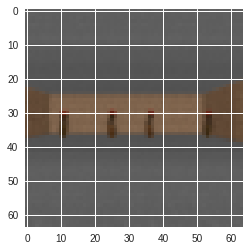

In [0]:
import urllib.request
url = 'http://folk.uio.no/charlepm/datasets/doom_images.npz'  
urllib.request.urlretrieve(url, './doom_images.npz') 
# http://folk.uio.no/charlepm/datasets/MetatoneTinyPerformanceRecords.h5

# Test loading new file.
with np.load('doom_images.npz') as data:
    image_data = data['arr_0']

# View an input
plt.imshow(image_data[np.random.randint(len(image_data))])

# The data, split between train and test sets:
x_train = image_data
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

In [0]:
# Hyperparameters
img_rows, img_cols, img_chns = 64, 64, 3
latent_dim = 16
intermediate_dim = 128
epsilon_std = 1.0
epochs = 100
filters = 32
num_conv = 3
batch_size = 256

img_size = (img_rows, img_cols, img_chns)
original_dim = img_rows * img_cols * img_chns

In [0]:
# Enc
input_img = Input(shape=img_size, name='encoder_input')
x = Conv2D(img_chns, kernel_size=(2,2), padding='same', activation='relu')(input_img)
x = Conv2D(filters, kernel_size=(2,2), padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(filters, kernel_size=(2,2), padding='same', activation='relu', strides=(2,2))(x)
# x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='same')(x) # try a max pooling layer here instead of the previous stride
x = Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1)(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu', name='latent_project')(x)

print("Shape before flattening:",shape_before_flattening)

# mean and var
z_mean = Dense(latent_dim, name='Z_mean')(x)
z_log_var = Dense(latent_dim, name='Z_var')(x)

# make an encoder model (not used until after training)
encoder = Model(input_img, z_mean)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling, name="Z_sample")([z_mean, z_log_var])

# dec
decoder_input = layers.Input(K.int_shape(z)[1:])
y = Dense(intermediate_dim, activation='relu')(decoder_input) # (z)
y = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(y)
y = Reshape(shape_before_flattening[1:])(y)
y = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu', name='deconv_1')(y) # deconv 1
y = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=(2,2), activation='relu', name='deconv_2')(y) # deconv 2
y = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu', name='deconv_3')(y) # deconv 3, upsamp
y = Conv2D(img_chns, kernel_size=2, padding='valid', activation='sigmoid', name="mean_squash")(y) # mean squash
decoder = Model(decoder_input, y, name="Decoder")
z_decoded = decoder(z) #y

def xent(y_true, y_pred):
  return keras.metrics.binary_crossentropy(y_true, y_pred)

def kl_measure(loc, log_var):
  return -0.5 * K.mean(1 + log_var - K.square(loc) - K.exp(log_var), axis=-1)
  
def kl_custom_metric(y_true, y_pred):
  # Ignore input and take from z tensors.
  return kl_measure(z_mean, z_log_var)
  
class VAELayer(keras.layers.Layer):    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(VAELayer, self).__init__(**kwargs)
      
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        r_loss = original_dim * xent(x, z_decoded)
        kl_loss = kl_measure(z_mean, z_log_var)
        print("KL Shape:", K.int_shape(kl_loss))
        print("Xent shape:", K.int_shape(r_loss))
        return K.mean(r_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = VAELayer()([input_img, z_decoded])

vae = Model(input_img, y, name="VAE")
vae.compile(optimizer='adam', metrics=['mse','binary_crossentropy'])


decoder.summary()
vae.summary()

Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_14 (Dense)             (None, 8192)              1056768   
_________________________________________________________________
reshape_7 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 16, 16, 32)        9248      
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 32, 32, 32)        9248      
_________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Output "vae_layer_7" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "vae_layer_7" during training.


In [0]:
# Train!
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
23874/23874 [==============================] - 16s 652us/step - loss: 7868.3378
Epoch 2/100
23874/23874 [==============================] - 12s 520us/step - loss: 7710.9189
Epoch 3/100
23874/23874 [==============================] - 12s 520us/step - loss: 7685.6194
Epoch 4/100
23874/23874 [==============================] - 12s 519us/step - loss: 7674.3624
Epoch 5/100
23874/23874 [==============================] - 12s 520us/step - loss: 7664.8164
Epoch 6/100
23874/23874 [==============================] - 12s 517us/step - loss: 7651.4374
Epoch 7/100
23874/23874 [==============================] - 12s 520us/step - loss: 7646.2585
Epoch 8/100
23874/23874 [==============================] - 12s 521us/step - loss: 7642.0280
Epoch 9/100
23874/23874 [==============================] - 12s 522us/step - loss: 7638.8426
Epoch 10/100
23874/23874 [==============================] - 12s 522us/step - loss: 7636.4284
Epoch 11/100
23874/23874 [==============================] - 12s 523us/step - lo

KeyError: ignored

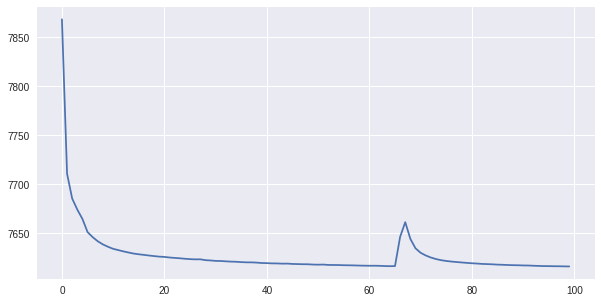

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

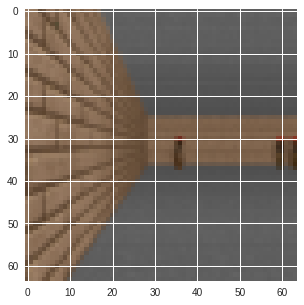

[ 1.6536994  -0.26253283 -0.3903028   0.6173528   2.2394063   0.01592673
 -0.10545388  0.18664919  0.02030399  0.93427134 -0.69859016 -0.2202897
 -0.9538159  -0.47826403  0.00329593 -1.9492817 ]


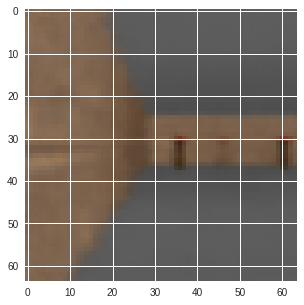

In [0]:
# Encoder part only:
ex = x_train[np.random.randint(len(x_train))]
plt.figure(figsize=(5, 5))
plt.imshow(ex) # cmap ignored if input is 3D (as it should be here)
plt.show()

enc_z = encoder.predict(np.array([ex]))
print(enc_z[0])

ex_dec = decoder.predict(np.array([enc_z[0]]))
# Plot output
plt.figure(figsize=(5, 5))
plt.imshow(ex_dec[0]) # cmap ignored if input is 3D (as it should be here)
plt.show()

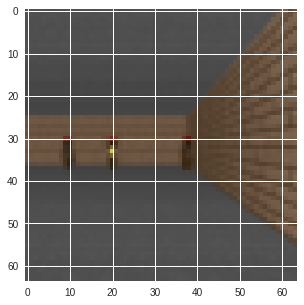

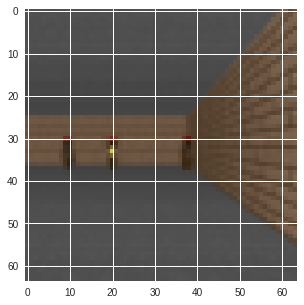

In [0]:
#Input
ex = x_train[np.random.randint(len(x_train))]
plt.figure(figsize=(5, 5))
plt.imshow(ex) # cmap ignored if input is 3D (as it should be here)
plt.show()

# Predict output
ex_dec = vae.predict(np.array([ex]))

# Plot output
plt.figure(figsize=(5, 5))
plt.imshow(ex_dec[0]) # cmap ignored if input is 3D (as it should be here)
plt.show()

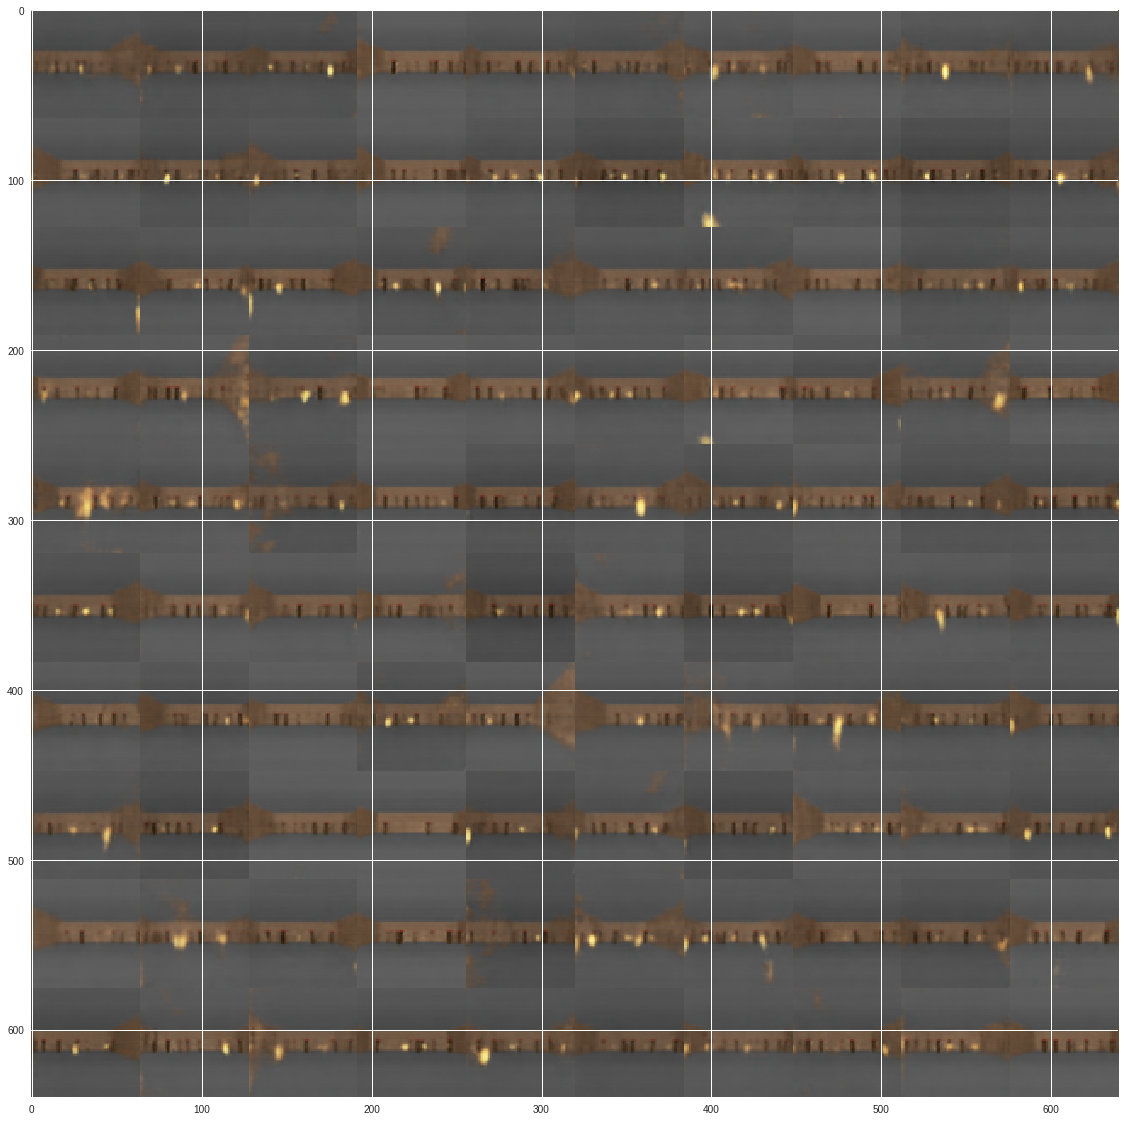

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# display images generated from randomly sampled latent vector
n = 10 # num images
img_size = 64
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(figure) # cmap ignored if input is 3D (as it should be here)
plt.show()


In [0]:
# Save and download models

def save_model_three_ways(model, name="model"):
  # Save the weights
  model.save("./models/doom_" + name + ('_ld_%d_conv_%d_id_%d_e_%d.h5' % (latent_dim, num_conv, intermediate_dim, epochs)))
  model.save_weights("./models/doom_" + name + '_weights.h5')
  # Save the model architecture
  with open("./models/doom_" + name + '_architecture.json', 'w') as f:
    f.write(model.to_json())

save_model_three_ways(vae, name="vae")
save_model_three_ways(encoder, name="encoder")
save_model_three_ways(encoder, name="decoder")

!tar -czvf doom_models.tar.gz models

from google.colab import files
files.download('doom_models.tar.gz')

models/
models/doom_encoder_architecture.json
models/doom_vae_architecture.json
models/doom_decoder_architecture.json
models/doom_encoder_weights.h5
models/doom_decoder_ld_16_conv_3_id_128_e_100.h5
models/doom_vae_ld_16_conv_3_id_128_e_50.h5
models/doom_vae_ld_16_conv_3_id_128_e_100.h5
models/doom_encoder_ld_16_conv_3_id_128_e_100.h5
models/doom_decoder_weights.h5
models/doom_vae_weights.h5


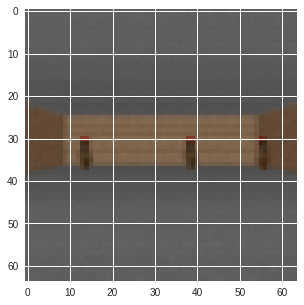

[-1.0344516  -0.5621151  -0.34114924 -0.30480352 -0.06532045 -0.09620504
  0.619046    0.11507718  0.0778223   0.14813815  0.17377195 -0.09505331
  0.14424488  0.8192186  -0.20691955  0.02276822]


In [0]:
# Encoder part only:
ex = x_train[1]
plt.figure(figsize=(5, 5))
plt.imshow(ex) # cmap ignored if input is 3D (as it should be here)
plt.show()

enc_z = encoder.predict(np.array([ex]))[0]
print(enc_z)
z_1 = enc_z[0]
z_2 = enc_z[1]
z_3 = enc_z[2]
z_4 = enc_z[3]
z_5 = enc_z[4]
z_6 = enc_z[5]
z_7 = enc_z[6]
z_8 = enc_z[7]
z_9 = enc_z[8]
z_10 = enc_z[9]
z_11 = enc_z[10]
z_12 = enc_z[11]
z_13 = enc_z[12]
z_14 = enc_z[13]
z_15 = enc_z[14]
z_16 = enc_z[15]

[-0.86 -0.93  0.39 -0.83  0.15  0.23  0.51 -0.8   0.77 -0.69  0.   -0.73
 -0.48 -0.6   0.56  0.52]


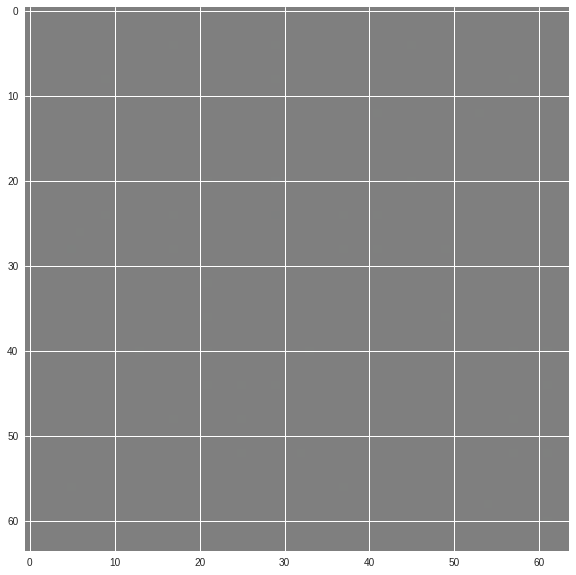

In [0]:
#@title Number fields { run: "auto", vertical-output: true, form-width: "50px" }
z_1 = -0.86 #@param {type:"slider", min:-1, max:1, step:0.01}
z_2 = -0.93 #@param {type:"slider", min:-1, max:1, step:0.01}
z_3 = 0.39 #@param {type:"slider", min:-1, max:1, step:0.01}
z_4 = -0.83 #@param {type:"slider", min:-1, max:1, step:0.01}
z_5 = 0.15 #@param {type:"slider", min:-1, max:1, step:0.01}
z_6 = 0.23 #@param {type:"slider", min:-1, max:1, step:0.01}
z_7 = 0.51 #@param {type:"slider", min:-1, max:1, step:0.01}
z_8 = -0.8 #@param {type:"slider", min:-1, max:1, step:0.01}
z_9 = 0.77 #@param {type:"slider", min:-1, max:1, step:0.01}
z_10 = -0.69 #@param {type:"slider", min:-1, max:1, step:0.01}
z_11 = 0 #@param {type:"slider", min:-1, max:1, step:0.01}
z_12 = -0.73 #@param {type:"slider", min:-1, max:1, step:0.01}
z_13 = -0.48 #@param {type:"slider", min:-1, max:1, step:0.01}
z_14 = -0.6 #@param {type:"slider", min:-1, max:1, step:0.01}
z_15 = 0.56 #@param {type:"slider", min:-1, max:1, step:0.01}
z_16 = 0.52 #@param {type:"slider", min:-1, max:1, step:0.01}

new_z= np.array([z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_10,z_11,z_12,z_13,z_14,z_15,z_16])
print(new_z)
dec = decoder.predict(np.array([new_z]))
plt.figure(figsize=(10, 10))
plt.imshow(dec[0]) # cmap ignored if input is 3D (as it should be here)
plt.show()